# EXP 1

 


In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy.random as rd
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import pandas as pd
import seaborn as sns
import random
import os

np.random.seed(28)

import sys
sys.path.append("..")


from gene_tr import *
from ML_estimator import ML
from Evaluation import *
from KF import *
from Basic import *
from EKF import *

In [2]:
# ML parameters
f=8.6e8
lmb = 3e8/f
print(f'ML parameters: f:{f},lmb:{lmb}')
#array
N=10 # number of elements
d=0.25*lmb # distance between 2 adjacent elements
arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location

filepath = 'C:/tests'
figsize = (12,9)

ML parameters: f:860000000.0,lmb:0.3488372093023256


# Generate data

In [3]:
def Exp1_generate_traj(N_tr,Length,dt,lmb,q):
    # trajectory parameters-1d
    F_1 = np.array([[1, dt], [0, 1]])
    H_1=np.array([1,0])  

    Q_1 =  (q**2)*np.array([[(dt**3)/3,(dt**2)/2],[(dt**2)/2,dt]]) 
    r = 0
    R_1 = r**2  # position observation noise

    # trajectory parameters-2d
    zero_2_2=np.zeros([2,2])
    zero_1_2=np.zeros([1,2])
    F = np.block([[F_1,zero_2_2],[zero_2_2,F_1]])
    H = np.block([[H_1,zero_1_2],[zero_1_2,H_1]])
    Q = np.block([[Q_1,zero_2_2],[zero_2_2,Q_1]])
    R = np.block([[R_1,0],[0,R_1]])

    # Generate N_tr trajectories and save them in a txt file
    real_states=np.zeros((N_tr,Length,4))

    for i in range (N_tr):
        #Initial speed
        v_x_start = np.random.uniform(3,5,1).squeeze()  #[3,5)  #x intial speed
        v_y_start = np.random.uniform(4,6,1).squeeze()  #[4,6)  #y initial speed
        X0 = np.array([0,v_x_start,1,v_y_start]).reshape(4,1)  #initial position not on (0,0) because there is an antenna
        r_s = GenerateTraj(Length,X0,F,Q) #genrate a trajectory from t=0 to t=(Length-1)*dt
        real_states[i,:,:] = r_s.reshape(Length,4)

    with open(f'../Experiments_data/trajectories_states_q_{q/lmb}lmb_l_{Length}_num_{N_tr}.txt', 'w') as outfile:
        for slice_2d in real_states:
            np.savetxt(outfile, slice_2d, fmt = '%f', delimiter = ',')


    real_states= np.loadtxt(f'../Experiments_data/trajectories_states_q_{q/lmb}lmb_l_{Length}_num_{N_tr}.txt', delimiter = ',').reshape((N_tr, Length, 4))


    return real_states


In [4]:
def Exp1_generate_obs(N_tr,Length,N_tr_used, Length_used, dt,position_noise_dB,lmb,N,arr,q,r_tr): 
    #Given N_tr*Length*4 real trajectories states with q, generate obsevations (positions, phases) under a specific noise level
    #r_tr: ratio allocated to training (computing R_ML)

    # trajectory parameters-1d
    F_1 = np.array([[1, dt], [0, 1]])
    H_1=np.array([1,0])  

    Q_1 =  (q**2)*np.array([[(dt**3)/3,(dt**2)/2],[(dt**2)/2,dt]]) 
    r = 0
    R_1 = r**2  # position observation noise

    # trajectory parameters-2d
    zero_2_2=np.zeros([2,2])
    zero_1_2=np.zeros([1,2])
    F = np.block([[F_1,zero_2_2],[zero_2_2,F_1]])
    H = np.block([[H_1,zero_1_2],[zero_1_2,H_1]])
    Q = np.block([[Q_1,zero_2_2],[zero_2_2,Q_1]])
    R = np.block([[R_1,0],[0,R_1]])


    real_states= np.loadtxt(f'../Experiments_data/trajectories_states_q_{q/lmb}lmb_l_{Length}_num_{N_tr}.txt', delimiter = ',').reshape((N_tr, Length, 4))
    real_states_used = real_states[:N_tr_used]
    real_states_used = real_states_used[:,:Length_used,:]

    #generate phases and noisy postions
    position_noise_std=Single_Noise_dB_to_std(position_noise_dB)

    # Generate phases
    Phases=np.empty([N_tr_used,Length_used,N])
    noisy_positions=np.empty([N_tr_used,Length_used,2])
    phase_offset=0.3
    Phases,noisy_positions= GeneratePhasesPositionsforTrajectories(N_tr_used,Length_used,arr,lmb,phase_offset,real_states_used,position_noise_std,0)

    #split the data into training set and test set
    num_train=int(r_tr*N_tr_used); num_test=N_tr_used-num_train
    Phases_train= Phases[0:num_train,:,:]; Phases_test=Phases[num_train:,:,:]
    states_train = real_states_used[0:num_train,:,:]; states_test= real_states_used[num_train:,:,:]
    noisy_positions_test = noisy_positions[num_train:,:,:]

    return position_noise_std,Phases_train,Phases_test,states_train,states_test,noisy_positions_test,H,F,Q

In [5]:
# Fixed q, ml_resol, search factor, different r

N_tr = 5000 #number of trajectories
Length = 200 #length of a trajectory
dt=0.1
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)
#--------------------------------------------------------------
#parameters tuning  

searchfactor_list=np.array([3])

ml_resol_list=np.array([0.0625*lmb])

q_list = np.array([lmb,0.5*lmb,0.25*lmb,0.125*lmb,0.0625*lmb])

In [6]:
# # #---------------------------------------------------------------
# # Generate data of trajectories, data are saved under directory Experiments_data
# for q in q_list:
#     print(f'q={q}[m]={q/lmb}wavelength')
#     real_states = Exp1_generate_traj(N_tr,Length,dt,lmb,q)

# estimate R_ml

In [7]:
def Estimate_MLencoder_MSE(Length, states_train, Phases_train, H, F, prior_std, arr, lmb, ml_resol,searchfactor):
    
    num_train = states_train.shape[0]
    ML_output = np.empty([num_train,Length,2])

    for i in range(num_train):
        Phases_i = Phases_train[i,:,:] # Phases of the i-th trajectory, size: Length*N
        for j in range(Length):
            #synthetic prior
            if(j==0):
                prior_mean=np.array([states_train[i,0,0],states_train[i,0,2]]) #[x0[0],x0[2]]  #prior info for x0 (or we do not have prior info for x0?)
            else:
                prior_mean=H@(F@states_train[i,j-1,:]) #Fx_t-1[0],Fx_t-1[2]
            #search space
            xrange_p=np.array([prior_mean[0]-searchfactor*prior_std,prior_mean[0]+searchfactor*prior_std])
            yrange_p=np.array([prior_mean[1]-searchfactor*prior_std,prior_mean[1]+searchfactor*prior_std])
            
            y_k=Phases_i[j,:]
            ml=ML()
            _,Loc_MLgrid=ml.ML_grid(xrange_p,yrange_p,y_k,arr,lmb,resolution=ml_resol,flag=False,flag_plot=False)
            ML_output[i,j]=Loc_MLgrid.reshape(2) 
    #compute MSE for x position and y position
    ML_output_x=ML_output[:,:,0].reshape([num_train,Length,1])
    ML_output_y=ML_output[:,:,1].reshape([num_train,Length,1])
    states_train_x=states_train[:,:,0].reshape([num_train,Length,1])
    states_train_y=states_train[:,:,2].reshape([num_train,Length,1])


    MSE_x_mean,MSE_x_std=evaluate(states_train_x,ML_output_x)
    MSE_y_mean,MSE_y_std=evaluate(states_train_y,ML_output_y)

    R_ML=np.array([[MSE_x_mean,0],[0,MSE_y_mean]])
    print(f'R_ML:{R_ML}')
    return R_ML

# EXP2: try ML + grid search and each times step with multiple iterations

In [8]:
def plot_example_Exp2(real_states,filter_result,filter_result_ite,dt,flag_save):
    
    plt.figure(figsize=figsize)
    plt.subplot(221)
    # plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,0], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,0], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result_ite)*dt,dt), filter_result_ite[1:,0], label = 'KF + ML encoder iteration',c='r',linestyle='--',linewidth=1)
   

    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.legend()


In [9]:
def Exp2(states_test,Length,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std,arr,Phases_test,position_noise_std,search_factor,Positions_test,flagplot):
    num_test=states_test.shape[0]
    KF_ML_output=np.empty([num_test,Length,4])
    KF_ML_ite_output=np.empty([num_test,Length,4])

    for i in range(num_test):
        
        #generate phases
        real_states_i=states_test[i,:,:].reshape(Length,4,1)
        Phases_i = Phases_test[i,:,:]
        
        #EXP2-1:KF+ML
        #init
        x0_KF = real_states_i[0,:,:].reshape(4,1)
        P0_KF=np.zeros([4,4])#initial state fully known

        z_i,filter_result_i = KF_ML(Length=Length,dt=dt,x0=x0_KF,P0=P0_KF,F=F,H=H,Q=Q,R=R_ML, #here! R should be replaced by the estimated MSE of ML encoder
                                                    lmb=lmb,ml_resol=ml_resol,std=prior_std,arr=arr,Phases=Phases_i,search_factor=search_factor)
        

        KF_ML_output[i]=filter_result_i

        
        #EXP2-2:KF+ML multiple iterations

        x0_KF = real_states_i[0,:,:].reshape(4,1)
        P0_KF=np.zeros([4,4])#initial state fully known

        z_ite_i,filter_result_ite_i,filter_result_ite_all_i = KF_ML_ite(Length=Length,dt=dt,x0=x0_KF,P0=P0_KF,F=F,H=H,Q=Q,R=R_ML, #here! R should be replaced by the estimated MSE of ML encoder
                                                    lmb=lmb,ml_resol=ml_resol,std=prior_std,arr=arr,Phases=Phases_i,search_factor=search_factor)
        

        KF_ML_ite_output[i]=filter_result_ite_i

        
        
        # #plot one trajectory
        if(i==0 and flagplot==True):
            plot_example_Exp2(real_states_i,KF_ML_output[i],KF_ML_ite_output[i],dt,flag_save=False)
    
    


    states_test_xy=np.stack([states_test[:,:,0],states_test[:,:,2]],axis=2)
    KF_ML_output_xy=np.stack([KF_ML_output[:,:,0],KF_ML_output[:,:,2]],axis=2)
    KF_ML_MSE_xy_mean,EF_ML_MSE_xy_std=evaluate(states_test_xy,KF_ML_output_xy)
    print(f'KF_ML_MSE_xy_mean:{KF_ML_MSE_xy_mean}')

    KF_ML_ite_output_xy = np.stack([KF_ML_ite_output[:,:,0],KF_ML_ite_output[:,:,2]],axis=2)
    KF_ML_ite_MSE_xy_mean,EF_ML_ite_MSE_xy_std = evaluate(states_test_xy,KF_ML_ite_output_xy)
    print(f'KF_ML_ite_MSE_xy_mean:{KF_ML_ite_MSE_xy_mean}')



    return KF_ML_MSE_xy_mean,KF_ML_ite_MSE_xy_mean

Begin experiment

In [10]:
# Fixed q, ml_resol, search factor
# Different Length_used, noise level (noise_dB), q_list

# Fixed parameters 
N_tr_used = 1000
searchfactor_list = np.array([3])
dt = 0.1
noise_dB = np.array([0,10,20,30])
position_noise_std = Noise_dB_to_std(noise_dB)
#--------------------------------------------------------------
# Parameters 

Length_used = 25 # can be changed to 50

ml_resol_list = np.array([0.0625*lmb])

q_list = np.array([0.0625*lmb,0.125*lmb,0.25*lmb])

In [ ]:
#---------------------------------------------------------------
#execute and save results
for q in q_list:
    for searchfactor in searchfactor_list:
        for ml_resol in ml_resol_list:
            #apply 2 methods
            KF_ML_MSE_xy_mean=np.empty(len(position_noise_std))
            KF_ML_ite_MSE_xy_mean=np.empty(len(position_noise_std))    
            for i in range(len(position_noise_std)):
                r_i=position_noise_std[i]*lmb #measurement noise level
                q_i=q
                prior_std_i=q_i
                print(f'q={q}[m]={q/lmb}wavelength')
                print(f'searchfactor:{searchfactor}')
                print(f'grid_size:{ml_resol/lmb}wavelength,grid_size={ml_resol/q}q')   
                print(f'positon noise [dB]={noise_dB[i]}')

                _,Phases_train,Phases_test,states_train,states_test,noisy_positions_test,H,F,Q = Exp1_generate_obs(N_tr,Length,N_tr_used,Length_used,dt,noise_dB[i],lmb,N,arr,q,r_tr=0.2)
                R_ML=Estimate_MLencoder_MSE(Length_used,states_train,Phases_train,H,F,prior_std_i,arr,lmb,ml_resol,searchfactor)
                KF_ML_MSE_xy_mean[i],KF_ML_ite_MSE_xy_mean[i] = Exp2(states_test,Length_used,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std_i,arr,Phases_test,position_noise_std[i],searchfactor,noisy_positions_test,flagplot=False)
                print('--------------')

            KF_ML_MSE_xy_mean_scale=KF_ML_MSE_xy_mean/(lmb**2)  #scale according to wavelenth
            KF_ML_MSE_mean_dB=todB(KF_ML_MSE_xy_mean_scale)
            KF_ML_ite_MSE_xy_mean_scale=KF_ML_ite_MSE_xy_mean/(lmb**2)  #scale according to wavelenth
            KF_ML_ite_MSE_mean_dB=todB(KF_ML_ite_MSE_xy_mean_scale)
            

            #save the results
            path = filepath+f"/trajectory_{Length_used}_compare"
            if not os.path.exists(path):
                os.mkdir(path)
            with open(path+f'/Tra_Exp1_MSE_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.3f}lmb_compare.txt', 'w') as outfile:
                np.savetxt(outfile, noise_dB,fmt = '%f', delimiter = ',')
                np.savetxt(outfile, KF_ML_MSE_mean_dB, fmt = '%f', delimiter = ',')
                np.savetxt(outfile, KF_ML_ite_MSE_mean_dB, fmt = '%f', delimiter = ',')
            

plot the result

In [15]:
def plot_result_EXP2(figsize,noise_dB,KF_ML_MSE_mean_dB,KF_ML_ite_MSE_dB):
    plt.figure(figsize=figsize)
    plt.plot(noise_dB,KF_ML_MSE_mean_dB,'o--',label=r'KF+ML',c='orange')
    plt.plot(noise_dB,KF_ML_ite_MSE_dB,'s--',label=r'KF+ML iteration',c='black')
   
    # plt.legend(bbox_to_anchor=(1, 1.15),ncol=3)
    plt.legend()

    # plt.xlabel(r'$σ^{-2}$ [dB(1/$rad^2$)]')
    plt.xlabel(r'$σ^{-2}$ [dB]')  
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    # plt.ylim([-40,20])
    plt.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


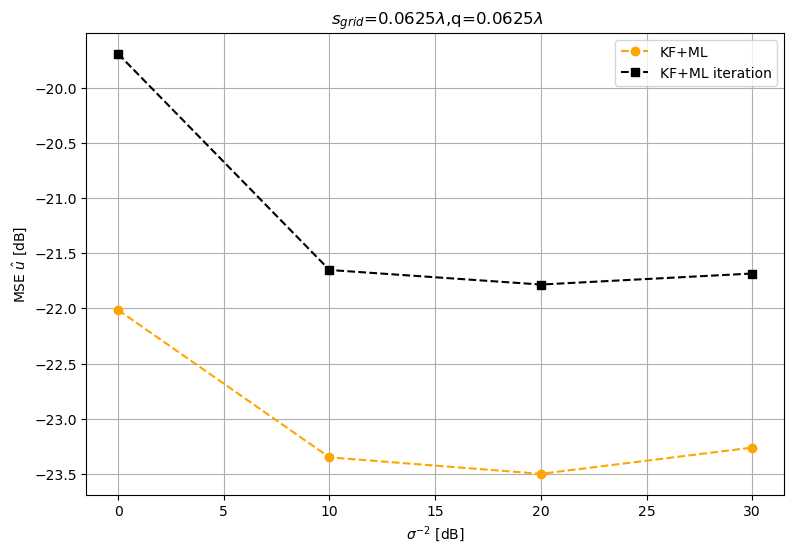

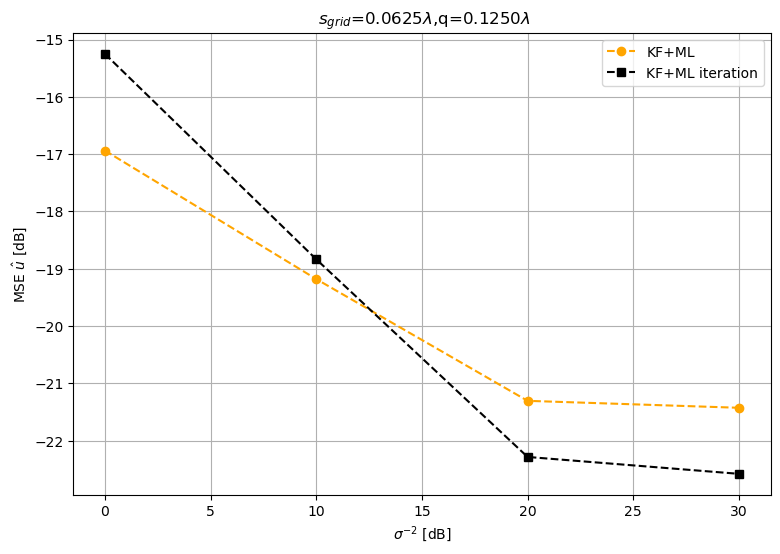

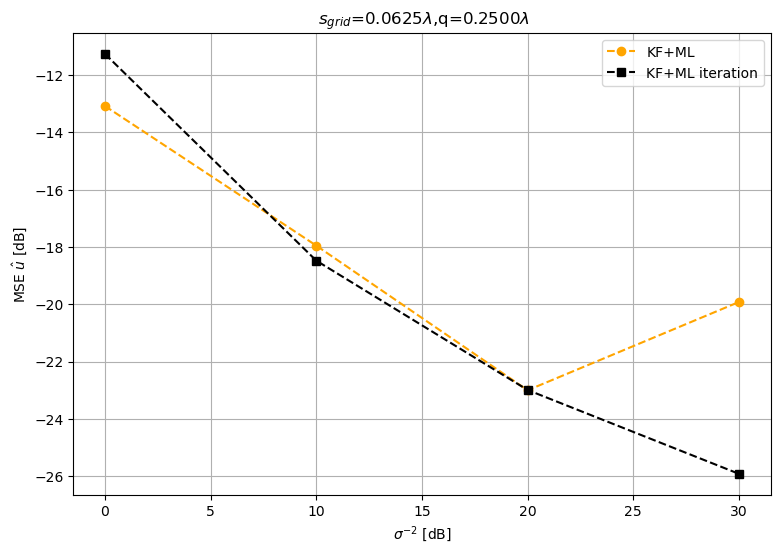

In [16]:
#---------------------------------------------------------------
#load and plot results
for q in q_list:
    for searchfactor in searchfactor_list:
        for ml_resol in ml_resol_list:
            
            path=filepath+f"/trajectory_{Length_used}_compare"
            #load the results
            data = np.loadtxt(path+f'/Tra_Exp1_MSE_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.3f}lmb_compare.txt')
            noise_dB=data[0:4]
            KF_ML_MSE_mean_dB=data[4:8]
            KF_ML_ite_MSE_mean_dB=data[8:12]


            #plot the results
            plot_result_EXP2((9,6),noise_dB,KF_ML_MSE_mean_dB,KF_ML_ite_MSE_mean_dB)
            plt.title(r" $s_{grid}$="+f"{ml_resol/lmb:.4f}"+r"$\lambda$"+f",q={q/lmb:.4f}"+r"$\lambda$")
    
            plt.savefig(path +f'/Tra_{Length_used}_Exp1_MSE_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.3f}lmb_compare'+'.png')
            plt.savefig(path +f'/Tra_{Length_used}_Exp1_MSE_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.3f}lmb_compare'+'.eps',format='eps') 
